In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

In [2]:
# Load data (data source: https://finance.yahoo.com/quote/MSFT/history/)
data = pd.read_csv(r"C:\Users\htet\Documents\backup\prediction_ms_stock_prices\MSFT.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400
...,...,...,...,...,...,...,...
9356,2023-04-27,295.970001,305.200012,295.250000,304.829987,304.829987,46462600
9357,2023-04-28,304.010010,308.929993,303.309998,307.260010,307.260010,36446700
9358,2023-05-01,306.970001,308.600006,305.149994,305.559998,305.559998,21294100
9359,2023-05-02,307.760010,309.179993,303.910004,305.410004,305.410004,26404400


In [3]:
def drop_columns(dataframe, cols):
    dataframe = dataframe.drop(cols, axis=1)
    return dataframe

data = drop_columns(data, ["Open", "High", "Low", "Adj Close", "Volume"])
data.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [4]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

data['Date'] = data['Date'].apply(str_to_datetime)
data['Date'].head()

0   1986-03-13
1   1986-03-14
2   1986-03-17
3   1986-03-18
4   1986-03-19
Name: Date, dtype: datetime64[ns]

In [5]:
data = data.set_index("Date")
data.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


In [6]:
data['Close'].describe()

count    9361.000000
mean       47.864888
std        69.759779
min         0.090278
25%         5.304688
50%        27.080000
75%        43.360001
max       343.109985
Name: Close, dtype: float64

Text(0.5, 1.0, 'Closing Values Over Time')

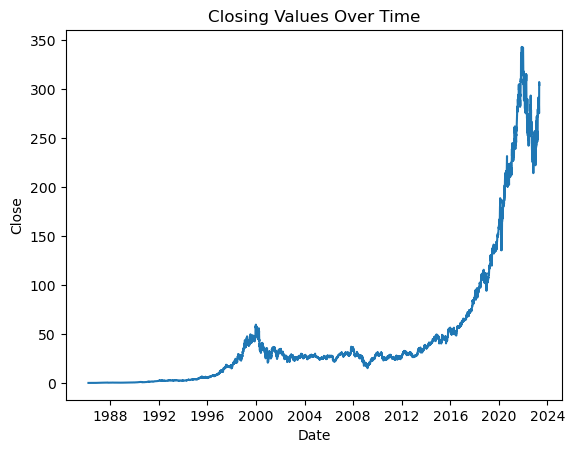

In [7]:
# Plot yearly closing values over time
plt.plot(data.index, data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Closing Values Over Time")

count     38.000000
mean      51.474578
std       75.109397
min        0.117596
25%        5.778952
50%       26.852981
75%       43.438429
max      275.940754
Name: Close, dtype: float64


Text(0.5, 1.0, 'Yearly Closing Value Over Time')

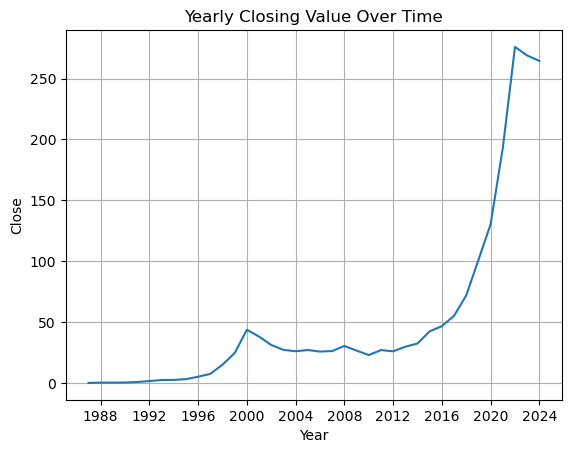

In [8]:
# Yearly data distribution
data_year = data.Close.resample('Y').mean()
print(data_year.describe())

# Plot quaterly closing value over time
plt.plot(data_year.index, data_year)
plt.xlabel("Year")
plt.ylabel("Close")
plt.grid()
plt.title("Yearly Closing Value Over Time")

count    150.000000
mean      48.710331
std       71.435336
min        0.096282
25%        5.267330
50%       27.024108
75%       44.339050
max      324.210157
Name: Close, dtype: float64


Text(0.5, 1.0, 'Quarterly Closing Value Over Time')

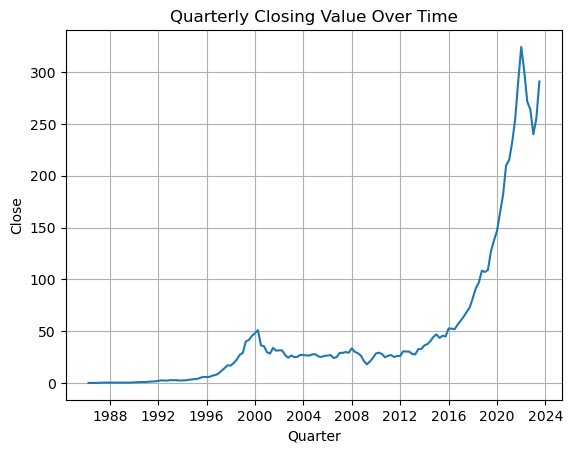

In [9]:
# Quarterly data distribution
data_quarter = data.Close.resample('Q').mean()
print(data_quarter.describe())

# Plot closing value over time
plt.plot(data_quarter.index, data_quarter)
plt.xlabel("Quarter")
plt.ylabel("Close")
plt.grid()
plt.title("Quarterly Closing Value Over Time")

count    447.000000
mean      48.411090
std       70.663067
min        0.096282
25%        5.456676
50%       27.075263
75%       43.514048
max      335.870950
Name: Close, dtype: float64


Text(0.5, 1.0, 'Monthly Closing Value Over Time')

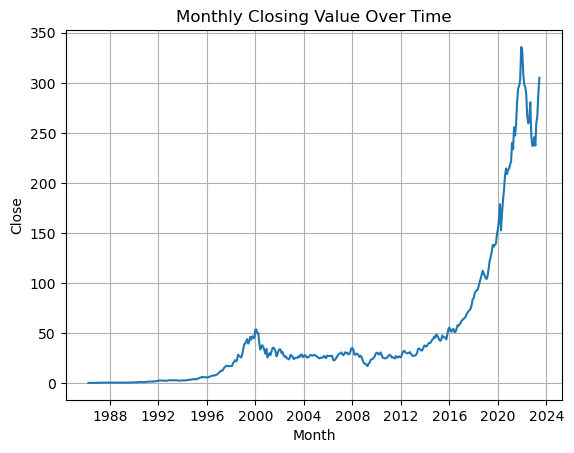

In [10]:
# Monthly data distribution
data_month = data.Close.resample('M').mean()
print(data_month.describe())

# Plot Monthly closing value over time
plt.plot(data_month.index, data_month)
plt.xlabel("Month")
plt.ylabel("Close")
plt.grid()
plt.title("Monthly Closing Value Over Time")

In [11]:
# Create windows based on lags
def create_window(df, lag):
    if lag < len(df):
        l = lag

        while True:
            df[f"Target_Close_{l}"] = df.Close.shift(l)

            l = l-1
            if l<1:
                break
        
        df["Target"] = df.Close.copy()
        return df
    
    else:
        raise ValueError(f"Lag value ({lag}) should be less than the size of data ({len(df)}).")

try:
    lag = 1
    target_data = data.copy()
    target_data = create_window(target_data, lag)
     
except ValueError as e:
    print(str(e))
    
target_data

,Close,Target_Close_1,Target
Date,,,
1986-03-13,0.097222,NaN,0.097222
1986-03-14,0.100694,0.097222,0.100694
1986-03-17,0.102431,0.100694,0.102431
1986-03-18,0.099826,0.102431,0.099826
1986-03-19,0.098090,0.099826,0.098090
...,...,...,...
2023-04-27,304.829987,295.369995,304.829987
2023-04-28,307.260010,304.829987,307.260010
2023-05-01,305.559998,307.260010,305.559998


In [12]:
# Delete redundant columns
deleted_cols = ["Close"]
target_data = drop_columns(target_data, deleted_cols)
target_data

,Target_Close_1,Target
Date,,
1986-03-13,NaN,0.097222
1986-03-14,0.097222,0.100694
1986-03-17,0.100694,0.102431
1986-03-18,0.102431,0.099826
1986-03-19,0.099826,0.098090
...,...,...
2023-04-27,295.369995,304.829987
2023-04-28,304.829987,307.260010
2023-05-01,307.260010,305.559998


In [13]:
# Choose data period
def selected_targets(dataframe, first_date, last_date):
    if first_date > dataframe.index[lag-1]:
        target_selected = dataframe.loc[first_date:last_date]
        return target_selected
    else:
        raise ValueError(f"First date should be greater than {first_date}.")     

try:  
    first_date = '1986-03-20'
    last_date = '2023-05-03'
    target_selected = selected_targets(target_data, str_to_datetime(first_date), str_to_datetime(last_date))
    print("Selected target shape: ", target_selected.shape)
    
except ValueError as e:
    print(str(e))

Selected target shape:  (9356, 2)


In [14]:
# Prepare data
def prepare_data(df):
    # convert df to numpy array
    dates = df.index.to_numpy()
    X = df.to_numpy()[:, :-1]
    y = df.to_numpy()[:, -1]
    return dates, X, y
    
dates, X, y = prepare_data(target_selected)
dates.shape, X.shape, y.shape

((9356,), (9356, 1), (9356,))

In [15]:
# Split train and test data
train_size = int(len(dates)*0.8)
dates_train = dates[:train_size]
X_train = X[:train_size]
y_train = y[:train_size]
dates_test = dates[train_size:]
X_test = X[train_size:]
y_test = y[train_size:]

X_train.shape, X_test.shape

((7484, 1), (1872, 1))

In [16]:
# Split train and validation data
train_nn_size = int(len(dates_train)*0.8)
dates_train_nn = dates_train[:train_nn_size]
X_train_nn = X_train[:train_nn_size]
y_train_nn = y_train[:train_nn_size]
dates_val_nn = dates_train[train_nn_size:]
X_val_nn = X_train[train_nn_size:]
y_val_nn = y_train[train_nn_size:]

X_train_nn.shape, X_val_nn.shape

((5987, 1), (1497, 1))

In [17]:
# Standardize X data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train_nn = scaler.transform(X_train_nn)
X_val_nn = scaler.transform(X_val_nn)

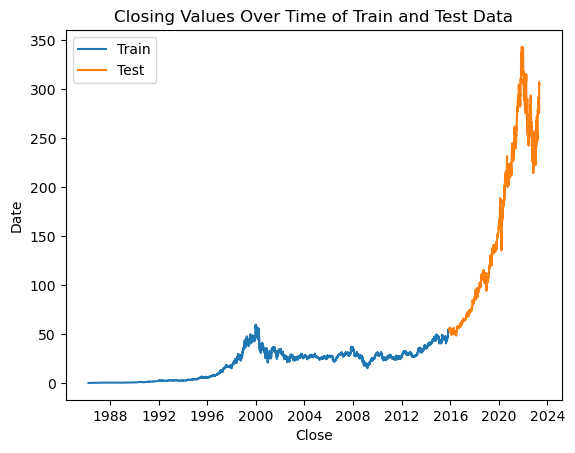

In [19]:
# Plot train and test data
plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)
plt.xlabel("Close")
plt.ylabel("Date")
plt.title("Closing Values Over Time of Train and Test Data")
plt.legend(["Train", "Test"])

In [ ]:
# Train and test target data distribution
# pd.DataFrame(y_train).describe(), pd.DataFrame(y_test).describe()

In [20]:
# Create linear regression model
model_lr = LinearRegression()

# Define the hyperparameter grid to search over
param_grid_lr = {'fit_intercept': [True, False]}

# Set the time series cross-validation scheme
cv_lr = TimeSeriesSplit(n_splits=6)

# Initialize arrays to store performance metrics
mae_scores_lr = np.zeros((len(param_grid_lr['fit_intercept'])))

for train_index, val_index in cv_lr.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    # Perform GridSearchCV on the training set
    grid_search_lr = GridSearchCV(model_lr, param_grid_lr, cv=cv_lr, n_jobs=-1)
    grid_search_lr.fit(X_train_cv, y_train_cv)

    # Train a final model on the entire training set using the best hyperparameters
    best_model = grid_search_lr.best_estimator_
    best_model.fit(X_train_cv, y_train_cv)

    # Evaluate performance on the validation set
    y_pred = best_model.predict(X_val_cv)
    mae_scores_lr += mean_absolute_error(y_val_cv, y_pred)

# Select the hyperparameters that resulted in the best performance
best_mae_lr_index = np.unravel_index(mae_scores_lr.argmin(), mae_scores_lr.shape)
best_params_lr = {'fit_intercept': np.take(param_grid_lr['fit_intercept'], best_mae_lr_index)}

print('Best linear regression hyperparameters:', best_params_lr)
print('MAE validation score:', mae_scores_lr[best_mae_lr_index])

Best linear regression hyperparameters: {'fit_intercept': array([ True])}
MAE validation score: 1.9474931441633694


In [22]:
# Create the SVR model
model_svr = SVR()

param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 5, 10, 50],
    'epsilon': [0.1, 0.2, 0.5]
}

cv_svr = TimeSeriesSplit(n_splits=6)

mae_scores_svr = np.zeros((len(param_grid_svr['kernel']), len(param_grid_svr['C']), len(param_grid_svr['epsilon'])))

for train_index, val_index in cv_lr.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    grid_search_svr = GridSearchCV(model_svr, param_grid_svr, cv=cv_svr, n_jobs=-1)
    grid_search_svr.fit(X_train_cv, y_train_cv)

    best_model = grid_search_svr.best_estimator_
    best_model.fit(X_train_cv, y_train_cv)

    y_pred = best_model.predict(X_val_cv)
    mae_scores_svr += mean_absolute_error(y_val_cv, y_pred)

best_mae_svr_index = np.unravel_index(mae_scores_svr.argmin(), mae_scores_svr.shape)
best_params_svr = {'kernel': param_grid_svr['kernel'][best_mae_svr_index[0]],
                   'C': param_grid_svr['C'][best_mae_svr_index[1]],
                   'epsilon': param_grid_svr['epsilon'][best_mae_svr_index[2]]}

print('Best SVR hyperparameters:', best_params_svr)
print('MAE validation score:', mae_scores_svr[best_mae_svr_index])

Best SVR hyperparameters: {'kernel': 'linear', 'C': 0.1, 'epsilon': 0.1}
MAE validation score: 2.222026969434655


In [23]:
# Create a random forest regression model
model_rf = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5]
}

cv_rf = TimeSeriesSplit(n_splits=6)

mae_scores_rf = np.zeros((len(param_grid_rf['n_estimators']), len(param_grid_rf['max_depth'])))

for train_index, val_index in cv_rf.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=cv_rf, n_jobs=-1)
    grid_search_rf.fit(X_train_cv, y_train_cv)

    best_model = grid_search_rf.best_estimator_
    best_model.fit(X_train_cv, y_train_cv)

    y_pred = best_model.predict(X_val_cv)
    mae_scores_rf += mean_absolute_error(y_val_cv, y_pred)

best_mae_rf_index = np.unravel_index(mae_scores_rf.argmin(), mae_scores_rf.shape)
best_params_rf = {'n_estimators': param_grid_rf['n_estimators'][best_mae_rf_index[0]],
                   'max_depth': param_grid_rf['max_depth'][best_mae_rf_index[1]]}

print('Best Random Forest hyperparameters:', best_params_rf)
print('MAE validation score:', mae_scores_rf[best_mae_rf_index])

Best Random Forest hyperparameters: {'n_estimators': 50, 'max_depth': None}
MAE validation score: 17.274967779976574


In [24]:
# Create Gradient Boosting Regressor model
model_gb = GradientBoostingRegressor()

param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'max_depth': [3, 5, 7]
}

cv_gb = TimeSeriesSplit(n_splits=6)

mae_scores_gb = np.zeros((len(param_grid_gb['n_estimators']), 
                           len(param_grid_gb['learning_rate']), 
                           len(param_grid_gb['max_depth'])))

for train_index, val_index in cv_lr.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=cv_gb, n_jobs=-1)
    grid_search_gb.fit(X_train_cv, y_train_cv)

    best_model = grid_search_gb.best_estimator_
    best_model.fit(X_train_cv, y_train_cv)

    y_pred = best_model.predict(X_val_cv)
    mae_scores_gb += mean_absolute_error(y_val_cv, y_pred)

best_mae_gb_index = np.unravel_index(mae_scores_gb.argmin(), mae_scores_gb.shape)
best_params_gb = {'n_estimators': param_grid_gb['n_estimators'][best_mae_gb_index[0]],
                   'learning_rate': param_grid_gb['learning_rate'][best_mae_gb_index[1]],
                   'max_depth': param_grid_gb['max_depth'][best_mae_gb_index[2]]}

print('Best Gradient Boosting hyperparameters:', best_params_gb)
print('MAE validation score:', mae_scores_gb[best_mae_gb_index])

Best Gradient Boosting hyperparameters: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
MAE validation score: 16.577477201787232


In [25]:
# Create KNeighborsRegressor model
model_kn = KNeighborsRegressor()

param_grid_kn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

cv_kn = TimeSeriesSplit(n_splits=6)

mae_scores_kn = np.zeros((len(param_grid_kn['n_neighbors']), len(param_grid_kn['weights'])))

for train_index, val_index in cv_kn.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    grid_search_kn = GridSearchCV(model_kn, param_grid_kn, cv=cv_kn, n_jobs=-1)
    grid_search_kn.fit(X_train_cv, y_train_cv)

    best_model = grid_search_kn.best_estimator_
    best_model.fit(X_train_cv, y_train_cv)

    y_pred = best_model.predict(X_val_cv)
    mae_scores_kn += mean_absolute_error(y_val_cv, y_pred)

best_mae_kn_index = np.unravel_index(mae_scores_kn.argmin(), mae_scores_kn.shape)
best_params_kn = {'n_neighbors': param_grid_kn['n_neighbors'][best_mae_kn_index[0]],
                   'weights': param_grid_kn['weights'][best_mae_kn_index[1]]}

print('Best KNeighbors Regressor hyperparameters:', best_params_kn)
print('MAE validation score:', mae_scores_kn[best_mae_rf_index])

Best Random Forest hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
MAE validation score: 17.40377235572534


In [28]:
# Define hyperparameters function
hp = HyperParameters()

# Create neural networks model
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 50)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=1024,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=3,
    executions_per_trial=1,
    directory='project',
    hyperparameters=hp,
    project_name='time_series_ep100_lag1')

# To stop early if there is no further changes in val_loss
callbacks = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, mode='min')

# Search the best hyperparameters and model
tuner.search(X_train_nn, y_train_nn, epochs=100, validation_data=(X_val_nn, y_val_nn), callbacks=[callbacks])

# Best hyperparameters
best_trials = tuner.oracle.get_best_trials(num_trials=1)
for trial in best_trials:
    print(trial.hyperparameters.values)
    
tuner.results_summary()

Trial 3 Complete [00h 01m 58s]
val_mean_absolute_error: 0.3506084084510803

Best val_mean_absolute_error So Far: 0.3506084084510803
Total elapsed time: 00h 02m 41s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 23, 'units_0': 416, 'units_1': 160, 'learning_rate': 1e-05, 'units_2': 192, 'units_3': 608, 'units_4': 608, 'units_5': 416, 'units_6': 960, 'units_7': 608, 'units_8': 128, 'units_9': 896, 'units_10': 160, 'units_11': 864, 'units_12': 544, 'units_13': 704, 'units_14': 224, 'units_15': 1024, 'units_16': 224, 'units_17': 800, 'units_18': 32, 'units_19': 32, 'units_20': 32, 'units_21': 32, 'units_22': 32}
Results summary
Results in project\time_series_ep100_lag1
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 23
units_0: 416
units_1: 160
learning_rate: 1e-05
units_2: 192
units_3: 608
units_4: 608
units_5: 416
units_6: 960
units_7: 608
units_8: 128
units_9: 896
units_10: 160
units_11: 864
units_12: 